## 5. Implementação Prática com Sentence-Transformers

### 🎯 **Por que Sentence-Transformers?**

O **Sentence-Transformers** é uma biblioteca Python que facilita o uso de modelos pré-treinados para gerar embeddings de alta qualidade. Diferente de embeddings de palavras individuais (Word2Vec), ele gera embeddings para **frases e documentos completos**.

**Vantagens:**
- 🚀 **Plug-and-play**: Modelos pré-treinados prontos para uso
- 🎯 **Semântica contextual**: Entende o significado completo das frases
- 🌍 **Multilíngue**: Suporte a diversos idiomas
- ⚡ **Eficiente**: Otimizado para produção

### 5.1 Sistema de Busca com Embeddings

In [15]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from typing import List, Tuple, Dict
import uuid

class EmbeddingSearchSystem:
    """
    🔍 Sistema de Busca Semântica com Embeddings
    
    Este sistema demonstra como construir um mecanismo de busca que entende
    o SIGNIFICADO do texto, não apenas palavras-chave exatas.
    
    Exemplo: Buscar por "cachorro" também encontrará textos sobre "cão" ou "pet"
    """
    
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2'):
        """
        🏗️ Inicialização do Sistema
        
        Args:
            model_name: Nome do modelo Sentence-Transformers
            
        📊 Modelos Populares:
        - 'all-MiniLM-L6-v2': Rápido, 384 dimensões, boa qualidade geral
        - 'all-mpnet-base-v2': Melhor qualidade, 768 dimensões, mais lento  
        - 'paraphrase-multilingual': Suporte multilíngue
        """
        print(f"🔄 Carregando modelo: {model_name}")
        self.model = SentenceTransformer(model_name)
        
        # 📚 Estruturas de dados do sistema
        self.documents = {}      # doc_id -> {text, metadata}
        self.embeddings = {}     # doc_id -> embedding_vector  
        self.document_ids = []   # Lista ordenada de IDs
        
        print(f"✅ Sistema inicializado com modelo {model_name}")
        print(f"📐 Dimensões dos embeddings: {self.model.get_sentence_embedding_dimension()}")
    
    def add_document(self, text: str, metadata: Dict = None) -> str:
        """
        ➕ Adicionar Documento ao Sistema
        
        Processo:
        1. Gera ID único para o documento
        2. Armazena texto e metadados  
        3. Converte texto em embedding vetorial
        4. Armazena embedding para buscas futuras
        
        Args:
            text: Texto do documento
            metadata: Informações adicionais (categoria, autor, etc.)
            
        Returns:
            doc_id: Identificador único do documento
        """
        doc_id = str(uuid.uuid4())
        print(f"📝 Adicionando documento: {doc_id[:8]}...")
        
        # 💾 Armazenar documento e metadados
        self.documents[doc_id] = {
            'text': text,
            'metadata': metadata or {}
        }
        
        # 🧠 Gerar embedding (conversão texto → vetor)
        print(f"🔄 Gerando embedding para: '{text[:50]}...'")
        embedding = self.model.encode([text])[0]
        self.embeddings[doc_id] = embedding
        self.document_ids.append(doc_id)
        
        print(f"✅ Documento adicionado com {len(embedding)} dimensões")
        return doc_id
    
    def remove_document(self, doc_id: str) -> bool:
        """
        🗑️ Remover Documento do Sistema
        
        Remove completamente o documento de todas as estruturas:
        - Texto e metadados
        - Embedding vetorial
        - Lista de IDs
        """
        if doc_id in self.documents:
            print(f"🗑️ Removendo documento: {doc_id[:8]}...")
            
            del self.documents[doc_id]
            del self.embeddings[doc_id] 
            self.document_ids.remove(doc_id)
            
            print("✅ Documento removido com sucesso")
            return True
        
        print("❌ Documento não encontrado")
        return False
    
    def search(self, query: str, top_k: int = 5) -> List[Tuple[str, float, str]]:
        """
        🔍 Buscar Documentos Similares
        
        Algoritmo de Busca Semântica:
        1. Converte consulta em embedding
        2. Calcula similaridade cosseno com todos os documentos
        3. Ordena por similaridade (maior = mais relevante)
        4. Retorna top_k mais similares
        
        Args:
            query: Texto da consulta
            top_k: Número máximo de resultados
            
        Returns:
            Lista de tuplas: (doc_id, similaridade, texto)
        """
        if not self.documents:
            print("⚠️ Nenhum documento no sistema")
            return []
        
        print(f"🔍 Buscando por: '{query}'")
        
        # 🧠 Converter consulta em embedding
        query_embedding = self.model.encode([query])[0]
        
        # 📊 Calcular similaridade com todos os documentos
        similarities = []
        for doc_id in self.document_ids:
            doc_embedding = self.embeddings[doc_id]
            
            # 📐 Similaridade cosseno: mede ângulo entre vetores
            # Valores: -1 (opostos) a 1 (idênticos)
            similarity = cosine_similarity([query_embedding], [doc_embedding])[0][0]
            similarities.append((doc_id, similarity, self.documents[doc_id]['text']))
        
        # 📈 Ordenar por relevância (similaridade decrescente)
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        print(f"📊 Encontrados {len(similarities)} documentos")
        return similarities[:top_k]
    
    def update_document(self, doc_id: str, new_text: str, new_metadata: Dict = None):
        """
        🔄 Atualizar Documento Existente
        
        Importante: Quando o texto muda, o embedding DEVE ser recalculado
        porque a representação vetorial mudou!
        """
        if doc_id in self.documents:
            print(f"🔄 Atualizando documento: {doc_id[:8]}...")
            
            # Atualizar texto e metadata
            self.documents[doc_id]['text'] = new_text
            if new_metadata:
                self.documents[doc_id]['metadata'].update(new_metadata)
            
            # 🧠 CRÍTICO: Regenerar embedding para novo texto
            embedding = self.model.encode([new_text])[0]
            self.embeddings[doc_id] = embedding
            
            print("✅ Documento e embedding atualizados")
            return True
        
        print("❌ Documento não encontrado")
        return False
    
    def save_system(self, filepath: str):
        """
        💾 Persistir Sistema em Arquivo
        
        Salva todo o estado do sistema:
        - Documentos e metadados
        - Embeddings pré-computados (economiza tempo!)
        - Lista de IDs
        
        ⚠️ Nota: O modelo não é salvo - deve ser recarregado na inicialização
        """
        print(f"💾 Salvando sistema em: {filepath}")
        
        system_data = {
            'documents': self.documents,
            'embeddings': self.embeddings,
            'document_ids': self.document_ids
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(system_data, f)
        
        print(f"✅ Sistema salvo com {len(self.documents)} documentos")
    
    def load_system(self, filepath: str):
        """
        📂 Carregar Sistema de Arquivo
        
        Restaura estado completo do sistema, incluindo embeddings
        pré-computados (evita recalcular tudo!)
        """
        print(f"📂 Carregando sistema de: {filepath}")
        
        with open(filepath, 'rb') as f:
            system_data = pickle.load(f)
        
        self.documents = system_data['documents']
        self.embeddings = system_data['embeddings']
        self.document_ids = system_data['document_ids']
        
        print(f"✅ Sistema carregado com {len(self.documents)} documentos")

# 🚀 EXEMPLO PRÁTICO EDUCACIONAL
def exemplo_sistema_busca():
    """
    📚 Demonstração Completa do Sistema de Busca Semântica
    
    Este exemplo mostra:
    1. Como inicializar o sistema
    2. Adicionar documentos com metadados
    3. Realizar buscas semânticas
    4. Interpretar resultados de similaridade
    5. Gerenciar documentos (adicionar/remover)
    """
    
    print("=" * 60)
    print("🎓 DEMONSTRAÇÃO: SISTEMA DE BUSCA SEMÂNTICA")
    print("=" * 60)
    
    # 🏗️ Inicializar sistema
    search_system = EmbeddingSearchSystem()
    
    # 📚 Conjunto de documentos sobre tecnologia
    documentos = [
        "Python é uma linguagem de programação versátil e fácil de aprender.",
        "Machine Learning utiliza algoritmos para encontrar padrões em dados.",
        "Embeddings convertem texto em representações vetoriais densas.",
        "Deep Learning é um subcampo do Machine Learning que usa redes neurais.",
        "Natural Language Processing permite que computadores entendam texto humano."
    ]
    
    print(f"\n📝 Adicionando {len(documentos)} documentos...")
    doc_ids = []
    for i, doc in enumerate(documentos):
        doc_id = search_system.add_document(
            doc, 
            {'categoria': 'tecnologia', 'indice': i}
        )
        doc_ids.append(doc_id)
    
    # 🔍 Demonstrar buscas semânticas
    queries = [
        "aprendizado de máquina",      # Deve encontrar ML e DL
        "programação em Python",       # Deve encontrar Python
        "processamento de texto"       # Deve encontrar NLP
    ]
    
    print(f"\n🔍 Realizando {len(queries)} buscas semânticas...")
    for query in queries:
        print(f"\n{'='*50}")
        print(f"🔍 Consulta: '{query}'")
        print('='*50)
        
        results = search_system.search(query, top_k=3)
        
        for i, (doc_id, similarity, text) in enumerate(results):
            print(f"\n{i+1}. 📊 Similaridade: {similarity:.3f}")
            print(f"   📝 Texto: {text}")
            print(f"   🆔 ID: {doc_id[:8]}...")
            
            # 💡 Interpretação educacional da similaridade
            if similarity > 0.7:
                print("   ✅ Alta relevância")
            elif similarity > 0.5:
                print("   🟡 Relevância moderada")
            else:
                print("   🔴 Baixa relevância")
    
    # 🗑️ Demonstrar remoção de documento
    print(f"\n{'='*50}")
    print("🗑️ DEMONSTRAÇÃO: REMOÇÃO DE DOCUMENTO")
    print('='*50)
    
    print(f"Removendo documento: {doc_ids[0][:8]}...")
    search_system.remove_document(doc_ids[0])
    
    # 🔍 Busca após remoção
    print(f"\n🔍 Busca após remoção por: 'Python'")
    results = search_system.search("Python", top_k=3)
    
    print(f"📊 Resultados encontrados: {len(results)}")
    for i, (doc_id, similarity, text) in enumerate(results):
        print(f"{i+1}. Similaridade: {similarity:.3f}")
        print(f"   {text[:60]}...")
    
    # 💾 Demonstrar persistência
    print(f"\n{'='*50}")
    print("💾 DEMONSTRAÇÃO: SALVAR/CARREGAR SISTEMA")
    print('='*50)
    
    filename = "sistema_busca.pkl"
    search_system.save_system(filename)
    
    # Criar novo sistema e carregar dados
    novo_sistema = EmbeddingSearchSystem()
    novo_sistema.load_system(filename)
    
    print("✅ Sistema recarregado com sucesso!")
    
    # 📊 Estatísticas finais
    print(f"\n{'='*50}")
    print("📊 ESTATÍSTICAS DO SISTEMA")
    print('='*50)
    print(f"📚 Total de documentos: {len(search_system.documents)}")
    print(f"🧠 Dimensões dos embeddings: {len(list(search_system.embeddings.values())[0])}")
    print(f"💾 Tamanho médio dos embeddings: {np.mean([emb.nbytes for emb in search_system.embeddings.values()])} bytes")

# 🎯 PONTOS-CHAVE PARA FIXAÇÃO
def pontos_chave_educacionais():
    """
    📝 Conceitos Fundamentais Demonstrados
    """
    print("\n" + "="*60)
    print("🎯 CONCEITOS-CHAVE APRENDIDOS")
    print("="*60)
    
    conceitos = [
        "🔍 Busca Semântica: Encontra significado, não apenas palavras exatas",
        "📊 Similaridade Cosseno: Mede ângulo entre vetores (0-1 para embeddings normalizados)",
        "🧠 Embeddings Contextuais: Capturam significado completo de frases/documentos",
        "💾 Persistência: Salvar embeddings evita recálculos custosos",
        "🔄 Atualização Dinâmica: Texto novo = embedding novo",
        "📈 Ranking por Relevância: Ordenação por similaridade decrescente"
    ]
    
    for conceito in conceitos:
        print(f"  {conceito}")
    
    print(f"\n💡 DICA PRÁTICA:")
    print("  Em produção, use índices aproximados (FAISS, Annoy) para")
    print("  buscas rápidas em milhões de documentos!")

# 🚀 Executar demonstração completa
if __name__ == "__main__":
    exemplo_sistema_busca()
    pontos_chave_educacionais()

🎓 DEMONSTRAÇÃO: SISTEMA DE BUSCA SEMÂNTICA
🔄 Carregando modelo: all-MiniLM-L6-v2
✅ Sistema inicializado com modelo all-MiniLM-L6-v2
📐 Dimensões dos embeddings: 384

📝 Adicionando 5 documentos...
📝 Adicionando documento: 187aa746...
🔄 Gerando embedding para: 'Python é uma linguagem de programação versátil e f...'
✅ Documento adicionado com 384 dimensões
📝 Adicionando documento: 4989d9d4...
🔄 Gerando embedding para: 'Machine Learning utiliza algoritmos para encontrar...'
✅ Documento adicionado com 384 dimensões
📝 Adicionando documento: ee22e16b...
🔄 Gerando embedding para: 'Embeddings convertem texto em representações vetor...'
✅ Documento adicionado com 384 dimensões
📝 Adicionando documento: 7b007919...
🔄 Gerando embedding para: 'Deep Learning é um subcampo do Machine Learning qu...'
✅ Documento adicionado com 384 dimensões
📝 Adicionando documento: 6a5218bb...
🔄 Gerando embedding para: 'Natural Language Processing permite que computador...'
✅ Documento adicionado com 384 dimensões

🔍 Re

## 5.2 Sistema Avançado com Chunking

### 🎯 **Conceitos Fundamentais**

Este sistema demonstra como lidar com **documentos longos** em aplicações reais de NLP, onde textos excedem os limites de processamento de modelos de linguagem.

**Por que precisamos de chunking?**
- **Limitações de modelos**: GPT-3.5 (4K tokens), BERT (512 tokens)
- **Qualidade de busca**: Chunks menores = resultados mais precisos
- **Performance**: Processamento paralelo de fragmentos independentes

In [ ]:
import re
from typing import List

class DocumentChunker:
    def __init__(self, chunk_size: int = 512, overlap: int = 50):
        """
        Inicializa o chunker com parâmetros configuráveis
        
        Args:
            chunk_size: Tamanho máximo do chunk em caracteres
            overlap: Número de caracteres de sobreposição entre chunks
        
        💡 Dica: chunk_size típico = 256-1024, overlap = 10-20% do chunk_size
        """
        self.chunk_size = chunk_size
        self.overlap = overlap
    
    def chunk_by_sentences(self, text: str) -> List[str]:
        """
        📝 ESTRATÉGIA 1: Divisão por Sentenças
        
        ✅ Vantagens:
        - Preserva integridade semântica das frases
        - Mantém contexto completo dentro de cada chunk
        - Ideal para textos narrativos e artigos
        
        ❌ Desvantagens:
        - Chunks podem ter tamanhos muito variados
        - Sentenças muito longas podem exceder o limite
        
        🎯 Melhor uso: Documentos com sentenças bem estruturadas
        """
        sentences = re.split(r'[.!?]+', text)
        chunks = []
        current_chunk = ""
        
        for sentence in sentences:
            sentence = sentence.strip()
            if not sentence:  # Pular sentenças vazias
                continue
                
            # Verificar se adicionar a sentença excede o limite
            potential_chunk = current_chunk + sentence + ". "
            
            if len(potential_chunk) < self.chunk_size:
                current_chunk = potential_chunk
            else:
                # Salvar chunk atual se não estiver vazio
                if current_chunk:
                    chunks.append(current_chunk.strip())
                # Iniciar novo chunk com a sentença atual
                current_chunk = sentence + ". "
        
        # Adicionar último chunk se houver conteúdo
        if current_chunk:
            chunks.append(current_chunk.strip())
        
        return chunks
    
    def chunk_by_tokens(self, text: str) -> List[str]:
        """
        🔤 ESTRATÉGIA 2: Divisão por Tokens (Palavras) com Sobreposição
        
        ✅ Vantagens:
        - Chunks de tamanho consistente
        - Sobreposição preserva contexto entre chunks
        - Controle preciso sobre o tamanho
        
        ❌ Desvantagens:
        - Pode quebrar sentenças no meio
        - Sobreposição pode causar redundância
        
        🎯 Melhor uso: Quando precisão de tamanho é crucial
        """
        words = text.split()
        chunks = []
        
        # Iterar com step = chunk_size - overlap para criar sobreposição
        for i in range(0, len(words), self.chunk_size - self.overlap):
            chunk_words = words[i:i + self.chunk_size]
            chunk_text = " ".join(chunk_words)
            chunks.append(chunk_text)
            
            # Parar se não há mais palavras suficientes
            if i + self.chunk_size >= len(words):
                break
        
        return chunks
    
    def chunk_by_paragraphs(self, text: str) -> List[str]:
        """
        📄 ESTRATÉGIA 3: Divisão por Parágrafos
        
        ✅ Vantagens:
        - Preserva estrutura lógica do documento
        - Mantém tópicos relacionados juntos
        - Respeita formatação original
        
        ❌ Desvantagens:
        - Parágrafos podem ser muito longos ou curtos
        - Dependente da qualidade da formatação
        
        🎯 Melhor uso: Documentos bem estruturados (artigos, papers)
        """
        paragraphs = text.split('\n\n')
        chunks = []
        current_chunk = ""
        
        for paragraph in paragraphs:
            paragraph = paragraph.strip()
            if not paragraph:
                continue
            
            potential_chunk = current_chunk + paragraph + "\n\n"
            
            if len(potential_chunk) < self.chunk_size:
                current_chunk = potential_chunk
            else:
                # Salvar chunk atual se não estiver vazio
                if current_chunk:
                    chunks.append(current_chunk.strip())
                # Verificar se parágrafo sozinho excede limite
                if len(paragraph) > self.chunk_size:
                    # Dividir parágrafo longo em sentenças
                    sentences = re.split(r'[.!?]+', paragraph)
                    temp_chunk = ""
                    for sentence in sentences:
                        if sentence.strip():
                            if len(temp_chunk + sentence) < self.chunk_size:
                                temp_chunk += sentence.strip() + ". "
                            else:
                                if temp_chunk:
                                    chunks.append(temp_chunk.strip())
                                temp_chunk = sentence.strip() + ". "
                    if temp_chunk:
                        current_chunk = temp_chunk
                else:
                    current_chunk = paragraph + "\n\n"
        
        if current_chunk:
            chunks.append(current_chunk.strip())
        
        return chunks

    def analyze_chunks(self, chunks: List[str]) -> None:
        """
        📊 Método auxiliar para analisar qualidade dos chunks
        """
        if not chunks:
            print("❌ Nenhum chunk foi gerado!")
            return
        
        sizes = [len(chunk) for chunk in chunks]
        word_counts = [len(chunk.split()) for chunk in chunks]
        
        print(f"📈 ANÁLISE DOS CHUNKS:")
        print(f"   Total de chunks: {len(chunks)}")
        print(f"   Tamanho médio: {sum(sizes)/len(sizes):.1f} caracteres")
        print(f"   Tamanho min/max: {min(sizes)}/{max(sizes)} caracteres")
        print(f"   Palavras médias por chunk: {sum(word_counts)/len(word_counts):.1f}")
        print(f"   Configuração: chunk_size={self.chunk_size}, overlap={self.overlap}")

In [ ]:
from sentence_transformers import SentenceTransformer
from typing import Dict, List

class AdvancedEmbeddingSystem:
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', chunk_size: int = 512):
        """
        🏗️ INICIALIZAÇÃO DO SISTEMA AVANÇADO
        
        Args:
            model_name: Modelo de embedding (all-MiniLM-L6-v2 = rápido e eficiente)
            chunk_size: Tamanho máximo dos chunks em caracteres
        
        💡 Escolha do modelo:
        - all-MiniLM-L6-v2: 384 dimensões, rápido, boa qualidade geral
        - all-mpnet-base-v2: 768 dimensões, melhor qualidade, mais lento
        - multilingual: Para textos em múltiplos idiomas
        """
        self.model = SentenceTransformer(model_name)
        self.chunker = DocumentChunker(chunk_size=chunk_size)
        self.search_system = EmbeddingSearchSystem(model_name)
    
    def add_long_document(self, text: str, doc_title: str = None, metadata: Dict = None) -> List[str]:
        """
        📄 PROCESSAMENTO DE DOCUMENTOS LONGOS
        
        Esta função resolve o problema fundamental: como processar textos
        que excedem os limites dos modelos de linguagem?
        
        Estratégia:
        1. Dividir documento em chunks menores
        2. Gerar embedding para cada chunk
        3. Manter rastreabilidade (qual chunk pertence a qual documento)
        
        Returns:
            Lista de IDs dos chunks criados
        """
        # ETAPA 1: Divisão inteligente do documento
        chunks = self.chunker.chunk_by_sentences(text)
        chunk_ids = []
        
        # ETAPA 2: Processar cada chunk individualmente
        for i, chunk in enumerate(chunks):
            # 🏷️ METADADOS ENRIQUECIDOS
            # Preservar informação sobre origem e posição do chunk
            chunk_metadata = metadata.copy() if metadata else {}
            chunk_metadata.update({
                'document_title': doc_title or f'Document_{len(self.search_system.documents)}',
                'chunk_index': i,                    # Posição no documento original
                'total_chunks': len(chunks),         # Total de chunks do documento
                'is_chunk': True                     # Flag para identificar chunks
            })
            
            # ETAPA 3: Adicionar chunk ao sistema de busca
            chunk_id = self.search_system.add_document(chunk, chunk_metadata)
            chunk_ids.append(chunk_id)
        
        return chunk_ids
    
    def search_with_context(self, query: str, top_k: int = 5) -> List[Dict]:
        """
        🔍 BUSCA CONTEXTUALIZADA
        
        Diferencial: Além da similaridade, retorna informações contextuais
        que ajudam o usuário a entender de onde veio o resultado.
        
        Informações contextuais incluem:
        - Título do documento original
        - Posição do chunk no documento
        - Metadados adicionais
        """
        # ETAPA 1: Busca semântica tradicional
        results = self.search_system.search(query, top_k)
        
        # ETAPA 2: Enriquecimento com contexto
        contextualized_results = []
        for doc_id, similarity, text in results:
            doc_info = self.search_system.documents[doc_id]
            
            # 📊 ESTRUTURA DE RESULTADO ENRIQUECIDA
            result = {
                'id': doc_id,
                'text': text,
                'similarity': similarity,
                'metadata': doc_info['metadata']
            }
            
            # 🔗 ADICIONAR CONTEXTO PARA CHUNKS
            if doc_info['metadata'].get('is_chunk', False):
                result['document_title'] = doc_info['metadata'].get('document_title')
                result['chunk_position'] = f"{doc_info['metadata']['chunk_index'] + 1}/{doc_info['metadata']['total_chunks']}"
            
            contextualized_results.append(result)
        
        return contextualized_results

### 🚀 **Exemplo Prático Educacional**

In [7]:
def exemplo_documento_longo():
    """
    📚 DEMONSTRAÇÃO COMPLETA: DO DOCUMENTO LONGO À BUSCA INTELIGENTE
    
    Este exemplo simula um cenário real onde você tem:
    - Um documento extenso sobre IA
    - Necessidade de fazer buscas específicas
    - Importância de manter contexto dos resultados
    """
    
    print("🎓 INICIANDO SISTEMA AVANÇADO DE EMBEDDINGS")
    print("=" * 60)
    
    # 🏗️ CONFIGURAÇÃO DO SISTEMA
    advanced_system = AdvancedEmbeddingSystem(chunk_size=200)
    
    # 📄 DOCUMENTO DE EXEMPLO (simulando artigo científico)
    documento_longo = """
    A inteligência artificial (IA) é uma área da ciência da computação que se concentra 
    na criação de sistemas capazes de realizar tarefas que normalmente requerem 
    inteligência humana. Isso inclui aprendizado, raciocínio, percepção, 
    processamento de linguagem natural e tomada de decisões.
    
    O machine learning é um subcampo da IA que permite que os computadores aprendam 
    e melhorem automaticamente através da experiência, sem serem explicitamente 
    programados para cada tarefa específica. Os algoritmos de machine learning 
    constroem modelos baseados em dados de treinamento para fazer previsões 
    ou tomar decisões.
    
    Deep learning, por sua vez, é um subcampo do machine learning que utiliza 
    redes neurais artificiais com múltiplas camadas para modelar e compreender 
    dados complexos. Essas redes são inspiradas no funcionamento do cérebro humano 
    e são especialmente eficazes em tarefas como reconhecimento de imagem, 
    processamento de linguagem natural e reconhecimento de fala.
    
    Os embeddings são uma técnica fundamental utilizada em muitas aplicações 
    de IA e NLP. Eles convertem dados categóricos ou textuais em representações 
    vetoriais densas que capturam relações semânticas. Isso permite que algoritmos 
    de machine learning trabalhem mais efetivamente com dados textuais, 
    encontrando padrões e similaridades que não seriam óbvios em representações 
    mais simples.
    """
    
    # 📥 PROCESSAMENTO DO DOCUMENTO
    print("📥 Processando documento longo...")
    chunk_ids = advanced_system.add_long_document(
        documento_longo, 
        "Introdução à Inteligência Artificial",
        {'autor': 'Sistema de Exemplos', 'categoria': 'educacional'}
    )
    
    print(f"✅ Documento dividido em {len(chunk_ids)} chunks")
    print(f"📊 IDs dos chunks: {chunk_ids[:3]}..." if len(chunk_ids) > 3 else f"📊 IDs: {chunk_ids}")
    
    # 🔍 DEMONSTRAÇÃO DE BUSCAS DIVERSIFICADAS
    queries = [
        "redes neurais",              # Busca por conceito específico
        "machine learning algoritmos", # Busca por área + método
        "embeddings semântica"        # Busca por técnica + propriedade
    ]
    
    print(f"\n🎯 Realizando {len(queries)} buscas demonstrativas...")
    
    for query_idx, query in enumerate(queries, 1):
        print(f"\n{'='*50}")
        print(f"🔍 BUSCA {query_idx}: '{query}'")
        print('='*50)
        
        # 🚀 EXECUTAR BUSCA CONTEXTUALIZADA
        results = advanced_system.search_with_context(query, top_k=3)
        
        if not results:
            print("❌ Nenhum resultado encontrado")
            continue
        
        # 📊 ANÁLISE DOS RESULTADOS
        print(f"📈 {len(results)} resultados encontrados:")
        
        for i, result in enumerate(results, 1):
            print(f"\n📄 RESULTADO {i}:")
            print(f"   🎯 Similaridade: {result['similarity']:.3f}")
            
            # 📍 INFORMAÇÕES CONTEXTUAIS
            if 'document_title' in result:
                print(f"   📚 Documento: {result['document_title']}")
            if 'chunk_position' in result:
                print(f"   📍 Posição: Chunk {result['chunk_position']}")
            
            # 📝 PREVIEW DO CONTEÚDO
            preview_text = result['text'][:100].replace('\n', ' ')
            print(f"   📝 Texto: {preview_text}...")
            
            # 🏷️ METADADOS ADICIONAIS
            metadata = result['metadata']
            if 'autor' in metadata:
                print(f"   👤 Autor: {metadata['autor']}")
            if 'categoria' in metadata:
                print(f"   🏷️ Categoria: {metadata['categoria']}")

# 🎓 EXECUTAR DEMONSTRAÇÃO
exemplo_documento_longo()

🎓 INICIANDO SISTEMA AVANÇADO DE EMBEDDINGS
🔄 Carregando modelo: all-MiniLM-L6-v2
✅ Sistema inicializado com modelo all-MiniLM-L6-v2
📐 Dimensões dos embeddings: 384
📥 Processando documento longo...
📝 Adicionando documento: 13ff8fa8...
🔄 Gerando embedding para: 'A inteligência artificial (IA) é uma área da ciênc...'
✅ Documento adicionado com 384 dimensões
📝 Adicionando documento: 1821d1d5...
🔄 Gerando embedding para: 'Isso inclui aprendizado, raciocínio, percepção, 
 ...'
✅ Documento adicionado com 384 dimensões
📝 Adicionando documento: 8d621c98...
🔄 Gerando embedding para: 'O machine learning é um subcampo da IA que permite...'
✅ Documento adicionado com 384 dimensões
📝 Adicionando documento: 2f352fd7...
🔄 Gerando embedding para: 'Os algoritmos de machine learning 
    constroem m...'
✅ Documento adicionado com 384 dimensões
📝 Adicionando documento: 4184fbdd...
🔄 Gerando embedding para: 'Deep learning, por sua vez, é um subcampo do machi...'
✅ Documento adicionado com 384 dimensões
📝 A

### 📊 **Análise Educacional dos Resultados**

============================================================
📊 ANÁLISE EDUCACIONAL DOS RESULTADOS
============================================================

    🎯 O QUE OBSERVAR NOS RESULTADOS:

    1. 📈 SCORES DE SIMILARIDADE:
       • 0.8-1.0: Correspondência muito alta (quase exata)
       • 0.6-0.8: Correspondência boa (semanticamente relacionada)
       • 0.4-0.6: Correspondência moderada (pode ser relevante)
       • 0.0-0.4: Correspondência baixa (pouco relevante)

    2. 🎪 CONTEXTO PRESERVADO:
       • Título do documento original mantido
       • Posição do chunk no documento (ex: "2/4" = chunk 2 de 4)
       • Metadados customizados preservados

    3. 🔍 QUALIDADE DA BUSCA:
       • "redes neurais" → deve encontrar parágrafo sobre deep learning
       • "algoritmos" → deve encontrar seção sobre machine learning
       • "embeddings" → deve encontrar parágrafo específico sobre embeddings

    4. ⚡ VANTAGENS DO CHUNKING:
       • Respostas mais precisas (chunks focados vs documento inteiro)
       • Melhor performance (embeddings menores)
       • Contexto preservado (sabemos de onde veio cada resultado)

### 🎓 **Pontos-Chave**

1. **🧩 Chunking Inteligente**: Dividir por sentenças preserva significado
2. **🏷️ Metadados Ricos**: Rastreabilidade é fundamental em sistemas reais
3. **🔍 Busca Contextualizada**: Não basta encontrar, precisa saber de onde veio
4. **⚖️ Trade-offs**: Chunks menores = mais precisão, mas mais complexidade
5. **🚀 Escalabilidade**: Sistema funciona com documentos de qualquer tamanho

## 5.3 Métricas e Avaliação

### 🎯 **Por que Avaliar Sistemas de Embeddings?**

A avaliação é fundamental para:
- **📊 Medir performance**: Quantificar quão bem o sistema funciona
- **🔍 Detectar problemas**: Identificar falhas na recuperação de documentos
- **⚖️ Comparar modelos**: Escolher a melhor abordagem para seu caso
- **🎯 Otimizar parâmetros**: Ajustar configurações do sistema
- **📈 Monitorar qualidade**: Acompanhar performance ao longo do tempo

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np
from typing import List, Tuple, Dict

class EmbeddingEvaluator:
    """
    🎓 CLASSE EDUCACIONAL: Avaliação de Sistemas de Embeddings
    
    Esta classe implementa métricas essenciais para avaliar:
    - Qualidade da busca semântica
    - Distribuição de similaridades
    - Estrutura do espaço de embeddings
    """
    
    def __init__(self, search_system):
        """
        Inicializar avaliador
        
        Args:
            search_system: Sistema de busca com embeddings (EmbeddingSearchSystem)
        """
        self.search_system = search_system
    
    def evaluate_search_quality(self, test_queries: List[Tuple[str, List[str]]]) -> Dict:
        """
        🎯 MÉTODO PRINCIPAL: Avaliar qualidade da busca usando queries de teste
        
        📚 CONCEITOS-CHAVE:
        - Precision@K: Proporção de documentos relevantes nos top-K resultados
        - Recall@K: Proporção dos documentos relevantes que foram encontrados
        - MRR: Mean Reciprocal Rank - posição média do primeiro resultado relevante
        
        Args:
            test_queries: Lista de tuplas (query, [doc_ids_relevantes])
            
        Returns:
            Dict com métricas calculadas
            
        💡 EXEMPLO DE USO:
        test_queries = [
            ("machine learning", ["doc1", "doc3", "doc7"]),
            ("python programming", ["doc2", "doc5"])
        ]
        """
        metrics = {
            'precision_at_k': [],  # Lista de tuplas (k, precision)
            'recall_at_k': [],     # Lista de tuplas (k, recall)
            'mrr': []              # Lista de valores MRR por query
        }
        
        print("🔍 AVALIANDO QUALIDADE DA BUSCA")
        print("=" * 50)
        
        for i, (query, relevant_docs) in enumerate(test_queries):
            print(f"\nQuery {i+1}: '{query}'")
            print(f"Documentos relevantes esperados: {len(relevant_docs)}")
            
            # Buscar documentos
            results = self.search_system.search(query, top_k=10)
            result_ids = [doc_id for doc_id, _, _ in results]
            
            print(f"Documentos retornados: {len(result_ids)}")
            
            # 📊 PRECISION@K e RECALL@K
            for k in [1, 3, 5, 10]:
                top_k_results = result_ids[:k]
                relevant_found = len(set(top_k_results) & set(relevant_docs))
                
                # Precision@K = Relevantes encontrados / K
                precision = relevant_found / k if k > 0 else 0
                
                # Recall@K = Relevantes encontrados / Total de relevantes
                recall = relevant_found / len(relevant_docs) if len(relevant_docs) > 0 else 0
                
                metrics['precision_at_k'].append((k, precision))
                metrics['recall_at_k'].append((k, recall))
                
                print(f"  P@{k}: {precision:.3f} | R@{k}: {recall:.3f}")
            
            # 🎯 MEAN RECIPROCAL RANK (MRR)
            # Encontra a posição do primeiro documento relevante
            for j, doc_id in enumerate(result_ids):
                if doc_id in relevant_docs:
                    mrr_score = 1 / (j + 1)  # Posição 1 = 1.0, Posição 2 = 0.5, etc.
                    metrics['mrr'].append(mrr_score)
                    print(f"  MRR: {mrr_score:.3f} (primeiro relevante na posição {j+1})")
                    break
            else:
                # Nenhum documento relevante encontrado
                metrics['mrr'].append(0)
                print(f"  MRR: 0.000 (nenhum documento relevante encontrado)")
        
        # 📈 RESUMO DAS MÉTRICAS
        self._print_metrics_summary(metrics)
        return metrics
    
    def _print_metrics_summary(self, metrics: Dict):
        """Imprimir resumo das métricas calculadas"""
        print("\n" + "="*50)
        print("📊 RESUMO DAS MÉTRICAS")
        print("="*50)
        
        # Agrupar métricas por K
        precision_by_k = {}
        recall_by_k = {}
        
        for k, precision in metrics['precision_at_k']:
            if k not in precision_by_k:
                precision_by_k[k] = []
            precision_by_k[k].append(precision)
        
        for k, recall in metrics['recall_at_k']:
            if k not in recall_by_k:
                recall_by_k[k] = []
            recall_by_k[k].append(recall)
        
        # Calcular médias
        print("Precision@K (média):")
        for k in sorted(precision_by_k.keys()):
            avg_precision = np.mean(precision_by_k[k])
            print(f"  P@{k}: {avg_precision:.3f}")
        
        print("\nRecall@K (média):")
        for k in sorted(recall_by_k.keys()):
            avg_recall = np.mean(recall_by_k[k])
            print(f"  R@{k}: {avg_recall:.3f}")
        
        avg_mrr = np.mean(metrics['mrr'])
        print(f"\nMRR médio: {avg_mrr:.3f}")
        
        # Interpretação educacional
        print("\n🎓 INTERPRETAÇÃO:")
        if avg_mrr > 0.7:
            print("✅ Excelente: Sistema encontra documentos relevantes nas primeiras posições")
        elif avg_mrr > 0.5:
            print("🟡 Bom: Sistema tem performance razoável")
        else:
            print("❌ Ruim: Sistema precisa de melhorias")
    
    def plot_similarity_distribution(self, query: str, num_samples: int = 100):
        """
        📊 VISUALIZAÇÃO: Distribuição de similaridades
        
        🎯 OBJETIVO: Entender como as similaridades se distribuem
        
        📚 O QUE ANALISAR:
        - Distribuição normal: Boa diversidade de documentos
        - Pico à esquerda: Muitos documentos irrelevantes
        - Pico à direita: Documentos muito similares (possível duplicação)
        - Distribuição uniforme: Falta de discriminação semântica
        """
        print(f"📊 ANALISANDO DISTRIBUIÇÃO DE SIMILARIDADES")
        print(f"Query: '{query}'")
        print("-" * 40)
        
        results = self.search_system.search(query, top_k=num_samples)
        similarities = [sim for _, sim, _ in results]
        
        if not similarities:
            print("❌ Nenhum resultado encontrado!")
            return
        
        # Estatísticas descritivas
        print(f"Número de documentos analisados: {len(similarities)}")
        print(f"Similaridade média: {np.mean(similarities):.3f}")
        print(f"Similaridade mediana: {np.median(similarities):.3f}")
        print(f"Desvio padrão: {np.std(similarities):.3f}")
        print(f"Min: {np.min(similarities):.3f} | Max: {np.max(similarities):.3f}")
        
        # Determinar número apropriado de bins
        n_bins = min(20, max(3, len(set(similarities))))
        
        # Criar visualização
        plt.figure(figsize=(12, 8))
        
        # Histograma principal
        plt.subplot(2, 2, 1)
        n, bins, patches = plt.hist(similarities, bins=n_bins, alpha=0.7, 
                                   edgecolor='black', color='skyblue')
        plt.title(f'Distribuição de Similaridades\nQuery: "{query}"')
        plt.xlabel('Similaridade (Cosseno)')
        plt.ylabel('Frequência')
        plt.grid(True, alpha=0.3)
        
        # Adicionar linha da média
        plt.axvline(np.mean(similarities), color='red', linestyle='--', 
                   label=f'Média: {np.mean(similarities):.3f}')
        plt.legend()
        
        # Box plot
        plt.subplot(2, 2, 2)
        plt.boxplot(similarities, vert=True)
        plt.title('Box Plot das Similaridades')
        plt.ylabel('Similaridade')
        plt.grid(True, alpha=0.3)
        
        # Distribuição cumulativa
        plt.subplot(2, 2, 3)
        sorted_sims = np.sort(similarities)
        cumulative = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
        plt.plot(sorted_sims, cumulative, marker='o', markersize=3)
        plt.title('Distribuição Cumulativa')
        plt.xlabel('Similaridade')
        plt.ylabel('Proporção Acumulada')
        plt.grid(True, alpha=0.3)
        
        # Top-K similarities
        plt.subplot(2, 2, 4)
        top_k = min(20, len(similarities))
        plt.plot(range(1, top_k + 1), similarities[:top_k], 
                marker='o', markersize=4, color='orange')
        plt.title(f'Top-{top_k} Similaridades')
        plt.xlabel('Ranking')
        plt.ylabel('Similaridade')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Interpretação educacional
        print("\n🎓 INTERPRETAÇÃO DA DISTRIBUIÇÃO:")
        if np.std(similarities) < 0.1:
            print("⚠️  Baixa variabilidade - documentos muito similares entre si")
        elif np.mean(similarities) < 0.3:
            print("⚠️  Similaridades baixas - possível problema de relevância")
        elif np.mean(similarities) > 0.8:
            print("⚠️  Similaridades muito altas - possível overfitting ou duplicação")
        else:
            print("✅ Distribuição saudável de similaridades")
    
    def analyze_embedding_space(self):
        """
        🔍 ANÁLISE AVANÇADA: Estrutura do espaço de embeddings
        
        🎯 OBJETIVO: Entender as propriedades geométricas do espaço vetorial
        
        📚 O QUE ANALISAMOS:
        - Dimensionalidade e densidade
        - Distribuição de normas (magnitudes dos vetores)
        - Matriz de similaridade entre todos os documentos
        - Clusters e padrões estruturais
        """
        print("🔍 ANÁLISE DO ESPAÇO DE EMBEDDINGS")
        print("=" * 50)
        
        if len(self.search_system.embeddings) < 2:
            print("❌ Não há embeddings suficientes para análise (mínimo: 2)")
            return
        
        # Converter embeddings para matriz numpy
        embeddings_matrix = np.array(list(self.search_system.embeddings.values()))
        doc_ids = list(self.search_system.embeddings.keys())
        
        # 📊 ESTATÍSTICAS BÁSICAS
        print("📊 ESTATÍSTICAS BÁSICAS:")
        print(f"  Número de documentos: {len(embeddings_matrix)}")
        print(f"  Dimensionalidade: {embeddings_matrix.shape[1]}")
        
        # Análise de normas (magnitudes dos vetores)
        norms = np.linalg.norm(embeddings_matrix, axis=1)
        print(f"  Norma média: {np.mean(norms):.3f}")
        print(f"  Desvio padrão da norma: {np.std(norms):.3f}")
        print(f"  Norma mín/máx: {np.min(norms):.3f} / {np.max(norms):.3f}")
        
        # Análise de distribuição por dimensão
        print(f"  Média por dimensão: {np.mean(np.mean(embeddings_matrix, axis=0)):.3f}")
        print(f"  Desvio padrão por dimensão: {np.mean(np.std(embeddings_matrix, axis=0)):.3f}")
        
        # 🎯 MATRIZ DE SIMILARIDADE
        print("\n🎯 CALCULANDO MATRIZ DE SIMILARIDADE...")
        similarity_matrix = cosine_similarity(embeddings_matrix)
        
        # Estatísticas da matriz de similaridade
        # Remover diagonal (similaridade consigo mesmo = 1.0)
        off_diagonal = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
        
        print(f"  Similaridade média entre documentos: {np.mean(off_diagonal):.3f}")
        print(f"  Desvio padrão das similaridades: {np.std(off_diagonal):.3f}")
        print(f"  Similaridade mín/máx: {np.min(off_diagonal):.3f} / {np.max(off_diagonal):.3f}")
        
        # 📊 VISUALIZAÇÕES
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Heatmap da matriz de similaridade
        ax1 = axes[0, 0]
        im = ax1.imshow(similarity_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        ax1.set_title('Matriz de Similaridade entre Documentos')
        ax1.set_xlabel('Documento ID')
        ax1.set_ylabel('Documento ID')
        plt.colorbar(im, ax=ax1)
        
        # 2. Distribuição das similaridades
        ax2 = axes[0, 1]
        # Determinar número apropriado de bins para similaridades
        n_bins_sim = min(30, max(5, len(set(off_diagonal))))
        ax2.hist(off_diagonal, bins=n_bins_sim, alpha=0.7, edgecolor='black', color='lightgreen')
        ax2.axvline(np.mean(off_diagonal), color='red', linestyle='--', 
                   label=f'Média: {np.mean(off_diagonal):.3f}')
        ax2.set_title('Distribuição das Similaridades')
        ax2.set_xlabel('Similaridade Cosseno')
        ax2.set_ylabel('Frequência')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Distribuição das normas
        ax3 = axes[1, 0]
        # Determinar número apropriado de bins para normas
        unique_norms = np.unique(norms)
        if len(unique_norms) < 3:
            # Se há poucas normas únicas, usar bar plot
            ax3.bar(range(len(unique_norms)), 
                   [np.sum(norms == norm) for norm in unique_norms],
                   alpha=0.7, color='orange')
            ax3.set_xticks(range(len(unique_norms)))
            ax3.set_xticklabels([f'{norm:.3f}' for norm in unique_norms])
            ax3.set_title('Distribuição das Normas dos Vetores')
            ax3.set_xlabel('Norma (Magnitude)')
            ax3.set_ylabel('Frequência')
        else:
            n_bins_norms = min(20, max(3, len(unique_norms)))
            ax3.hist(norms, bins=n_bins_norms, alpha=0.7, edgecolor='black', color='orange')
            ax3.axvline(np.mean(norms), color='red', linestyle='--', 
                       label=f'Média: {np.mean(norms):.3f}')
            ax3.set_title('Distribuição das Normas dos Vetores')
            ax3.set_xlabel('Norma (Magnitude)')
            ax3.set_ylabel('Frequência')
            ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Heatmap de correlação entre dimensões (amostra)
        ax4 = axes[1, 1]
        # Usar apenas primeiras 20 dimensões para visualização
        sample_dims = min(20, embeddings_matrix.shape[1])
        correlation_matrix = np.corrcoef(embeddings_matrix[:, :sample_dims].T)
        im4 = ax4.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        ax4.set_title(f'Correlação entre Dimensões\n(Primeiras {sample_dims} dimensões)')
        ax4.set_xlabel('Dimensão')
        ax4.set_ylabel('Dimensão')
        plt.colorbar(im4, ax=ax4)
        
        plt.tight_layout()
        plt.show()
        
        # 🎓 INTERPRETAÇÃO EDUCACIONAL
        print("\n🎓 INTERPRETAÇÃO DOS RESULTADOS:")
        print("-" * 40)
        
        if np.std(norms) < 0.1:
            print("✅ Normas consistentes - embeddings bem normalizados")
        else:
            print("⚠️  Normas variáveis - considere normalização L2")
        
        if np.mean(off_diagonal) > 0.7:
            print("⚠️  Similaridades muito altas - possível falta de diversidade")
        elif np.mean(off_diagonal) < 0.1:
            print("⚠️  Similaridades muito baixas - documentos muito diferentes")
        else:
            print("✅ Distribuição saudável de similaridades")
        
        if np.std(off_diagonal) < 0.1:
            print("⚠️  Pouca variabilidade - embeddings podem estar saturados")
        else:
            print("✅ Boa variabilidade nas similaridades")
        
        # Detectar possíveis clusters
        high_similarity_pairs = np.sum(off_diagonal > 0.8)
        total_pairs = len(off_diagonal)
        cluster_ratio = high_similarity_pairs / total_pairs
        
        print(f"\n🔍 DETECÇÃO DE CLUSTERS:")
        print(f"  Pares com alta similaridade (>0.8): {high_similarity_pairs}/{total_pairs} ({cluster_ratio:.1%})")
        
        if cluster_ratio > 0.3:
            print("🎯 Possíveis clusters detectados - documentos agrupados por temas")
        else:
            print("📊 Distribuição uniforme - boa diversidade temática")

🎓 DEMONSTRAÇÃO: SISTEMA DE AVALIAÇÃO DE EMBEDDINGS
🔍 AVALIANDO QUALIDADE DA BUSCA

Query 1: 'aprendizado de máquina'
Documentos relevantes esperados: 2
Documentos retornados: 5
  P@1: 0.000 | R@1: 0.000
  P@3: 0.333 | R@3: 0.500
  P@5: 0.400 | R@5: 1.000
  P@10: 0.200 | R@10: 1.000
  MRR: 0.500 (primeiro relevante na posição 2)

Query 2: 'linguagem de programação'
Documentos relevantes esperados: 1
Documentos retornados: 5
  P@1: 1.000 | R@1: 1.000
  P@3: 0.333 | R@3: 1.000
  P@5: 0.200 | R@5: 1.000
  P@10: 0.100 | R@10: 1.000
  MRR: 1.000 (primeiro relevante na posição 1)

Query 3: 'inteligência artificial'
Documentos relevantes esperados: 3
Documentos retornados: 5
  P@1: 1.000 | R@1: 0.333
  P@3: 1.000 | R@3: 1.000
  P@5: 0.600 | R@5: 1.000
  P@10: 0.300 | R@10: 1.000
  MRR: 1.000 (primeiro relevante na posição 1)

📊 RESUMO DAS MÉTRICAS
Precision@K (média):
  P@1: 0.667
  P@3: 0.556
  P@5: 0.400
  P@10: 0.200

Recall@K (média):
  R@1: 0.444
  R@3: 0.833
  R@5: 1.000
  R@10: 1.000

M

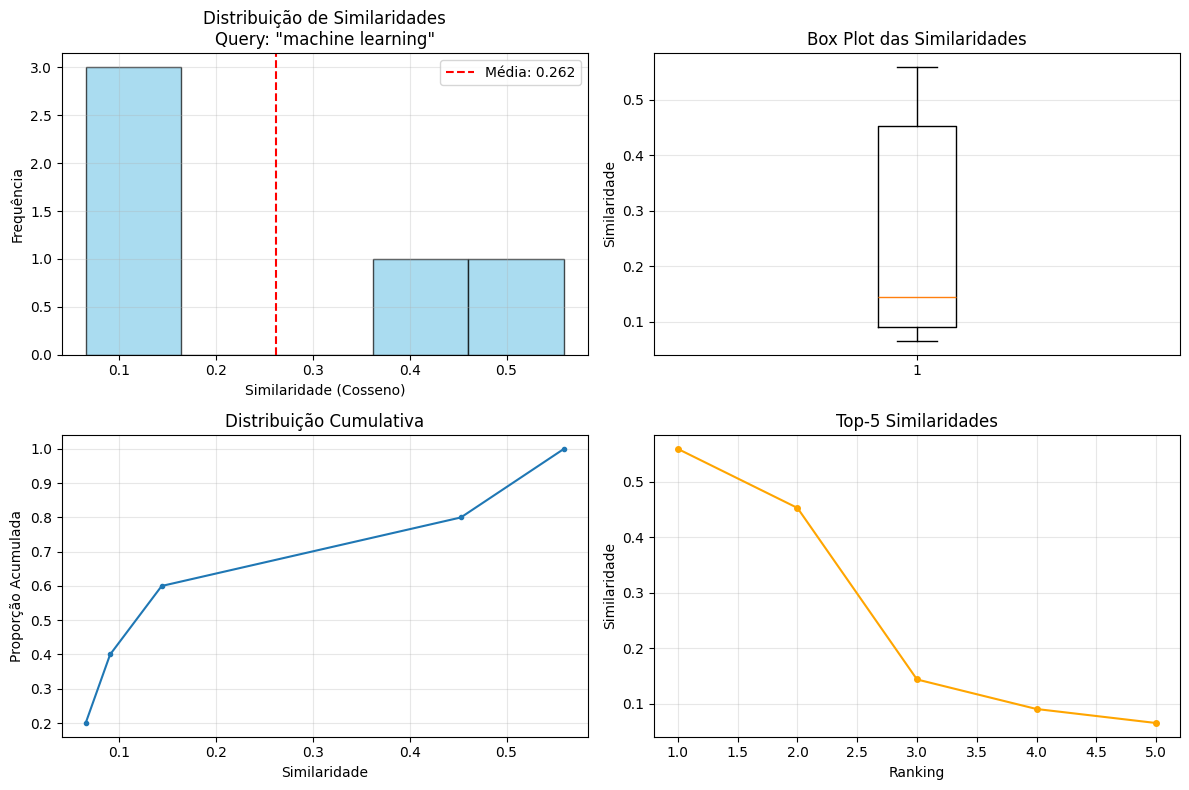


🎓 INTERPRETAÇÃO DA DISTRIBUIÇÃO:
⚠️  Similaridades baixas - possível problema de relevância
🔍 ANÁLISE DO ESPAÇO DE EMBEDDINGS
📊 ESTATÍSTICAS BÁSICAS:
  Número de documentos: 5
  Dimensionalidade: 384
  Norma média: 1.000
  Desvio padrão da norma: 0.000
  Norma mín/máx: 1.000 / 1.000
  Média por dimensão: -0.000
  Desvio padrão por dimensão: 0.036

🎯 CALCULANDO MATRIZ DE SIMILARIDADE...
  Similaridade média entre documentos: 0.285
  Desvio padrão das similaridades: 0.110
  Similaridade mín/máx: 0.171 / 0.484


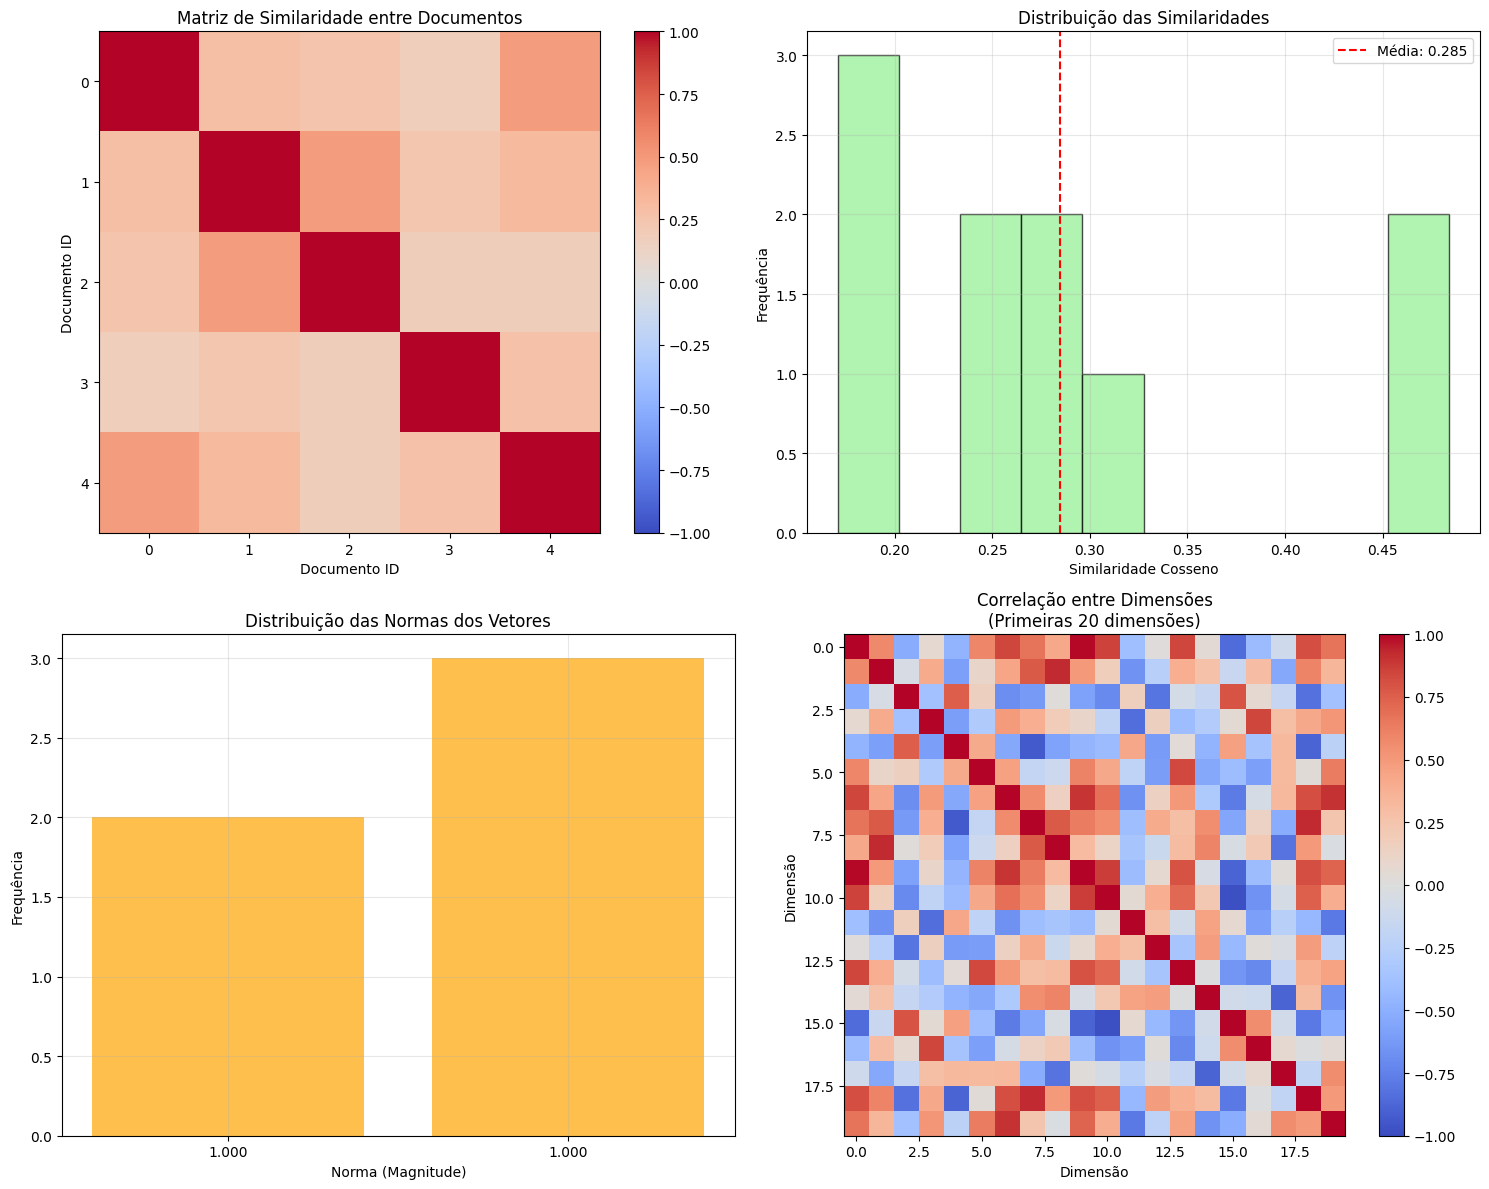


🎓 INTERPRETAÇÃO DOS RESULTADOS:
----------------------------------------
✅ Normas consistentes - embeddings bem normalizados
✅ Distribuição saudável de similaridades
✅ Boa variabilidade nas similaridades

🔍 DETECÇÃO DE CLUSTERS:
  Pares com alta similaridade (>0.8): 0/10 (0.0%)
📊 Distribuição uniforme - boa diversidade temática


In [19]:
# 🚀 EXEMPLO DE USO EDUCACIONAL
def exemplo_avaliacao_completa():
    """Demonstração completa do sistema de avaliação"""
    print("🎓 DEMONSTRAÇÃO: SISTEMA DE AVALIAÇÃO DE EMBEDDINGS")
    print("=" * 60)
    
    # Simular sistema de busca com documentos de exemplo
    from sentence_transformers import SentenceTransformer
    import uuid
    
    class EmbeddingSearchSystem:
        def __init__(self):
            self.model = SentenceTransformer('all-MiniLM-L6-v2')
            self.documents = {}
            self.embeddings = {}
            self.document_ids = []
        
        def add_document(self, text, metadata=None):
            doc_id = str(uuid.uuid4())
            self.documents[doc_id] = {'text': text, 'metadata': metadata or {}}
            embedding = self.model.encode([text])[0]
            self.embeddings[doc_id] = embedding
            self.document_ids.append(doc_id)
            return doc_id
        
        def search(self, query, top_k=5):
            if not self.documents:
                return []
            
            query_embedding = self.model.encode([query])[0]
            similarities = []
            
            for doc_id in self.document_ids:
                doc_embedding = self.embeddings[doc_id]
                similarity = cosine_similarity([query_embedding], [doc_embedding])[0][0]
                similarities.append((doc_id, similarity, self.documents[doc_id]['text']))
            
            similarities.sort(key=lambda x: x[1], reverse=True)
            return similarities[:top_k]
    
    search_system = EmbeddingSearchSystem()
    
    # Adicionar documentos de exemplo
    documentos_exemplo = [
        "Python é uma linguagem de programação versátil",
        "Machine learning utiliza algoritmos para encontrar padrões",
        "Deep learning é um subcampo do machine learning",
        "Redes neurais artificiais imitam o cérebro humano",
        "Processamento de linguagem natural permite compreender texto"
    ]
    
    doc_ids = []
    for doc in documentos_exemplo:
        doc_id = search_system.add_document(doc)
        doc_ids.append(doc_id)
    
    # Criar avaliador
    evaluator = EmbeddingEvaluator(search_system)
    
    # Definir queries de teste
    test_queries = [
        ("aprendizado de máquina", [doc_ids[1], doc_ids[2]]),  # ML e DL
        ("linguagem de programação", [doc_ids[0]]),             # Python
        ("inteligência artificial", [doc_ids[1], doc_ids[2], doc_ids[3]])  # ML, DL, NN
    ]
    
    # 1. Avaliar qualidade da busca
    metrics = evaluator.evaluate_search_quality(test_queries)
    
    # 2. Analisar distribuição de similaridades
    evaluator.plot_similarity_distribution("machine learning")
    
    # 3. Analisar espaço de embeddings
    evaluator.analyze_embedding_space()

# Executar exemplo
exemplo_avaliacao_completa()

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer

# Load your sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Example: Binary classification using embeddings
def evaluate_embedding_classifier(texts, labels):
    # Generate embeddings
    embeddings = model.encode(texts)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.3, random_state=42
    )
    
    # Train classifier
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    # Get prediction probabilities
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc, y_test, y_proba

In [21]:
def plot_roc_curves(results_dict):
    """Plot multiple ROC curves using seaborn styling"""
    plt.figure(figsize=(10, 8))
    sns.set_style("whitegrid")
    
    colors = sns.color_palette("husl", len(results_dict))
    
    for i, (model_name, (fpr, tpr, auc_score)) in enumerate(results_dict.items()):
        plt.plot(fpr, tpr, color=colors[i], lw=2, 
                label=f'{model_name} (AUC = {auc_score:.3f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    
    # Seaborn styling
    sns.despine()
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curve(y_true, y_proba):
    """Plot Precision-Recall curve"""
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    
    plt.plot(recall, precision, color='darkorange', lw=2,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    plt.fill_between(recall, precision, alpha=0.2, color='darkorange')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left")
    
    sns.despine()
    plt.tight_layout()
    plt.show()

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def comprehensive_evaluation(embeddings, labels, test_size=0.3):
    """Complete evaluation pipeline with visualizations"""
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=test_size, random_state=42
    )
    
    # Train model
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    # Predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Metrics
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # ROC Curve
    axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curve')
    axes[0, 0].legend()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    axes[0, 1].plot(recall, precision, color='blue', lw=2,
                    label=f'PR Curve (AUC = {pr_auc:.3f})')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_ylabel('True Label')
    axes[1, 0].set_xlabel('Predicted Label')
    
    # Feature importance (if applicable)
    if hasattr(clf, 'coef_'):
        feature_importance = np.abs(clf.coef_[0])
        top_features = np.argsort(feature_importance)[-10:]
        
        axes[1, 1].barh(range(len(top_features)), feature_importance[top_features])
        axes[1, 1].set_title('Top 10 Feature Importance')
        axes[1, 1].set_xlabel('Absolute Coefficient Value')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'model': clf,
        'predictions': y_pred,
        'probabilities': y_proba
    }

In [23]:
def analyze_embedding_similarities(texts, model):
    """Analyze and visualize embedding similarities"""
    embeddings = model.encode(texts)
    
    # Calculate cosine similarity matrix
    from sklearn.metrics.pairwise import cosine_similarity
    similarity_matrix = cosine_similarity(embeddings)
    
    # Visualization
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(similarity_matrix, dtype=bool))
    
    sns.heatmap(similarity_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.3f')
    
    plt.title('Cosine Similarity Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return similarity_matrix

🚀 EXEMPLO: AVALIAÇÃO COMPLETA COM EMBEDDINGS
📊 Dataset created:
   Total texts: 16
   Positive samples: 8
   Negative samples: 8

🤖 Loading model and generating embeddings...
   Embeddings shape: (16, 384)

📈 Running comprehensive evaluation...


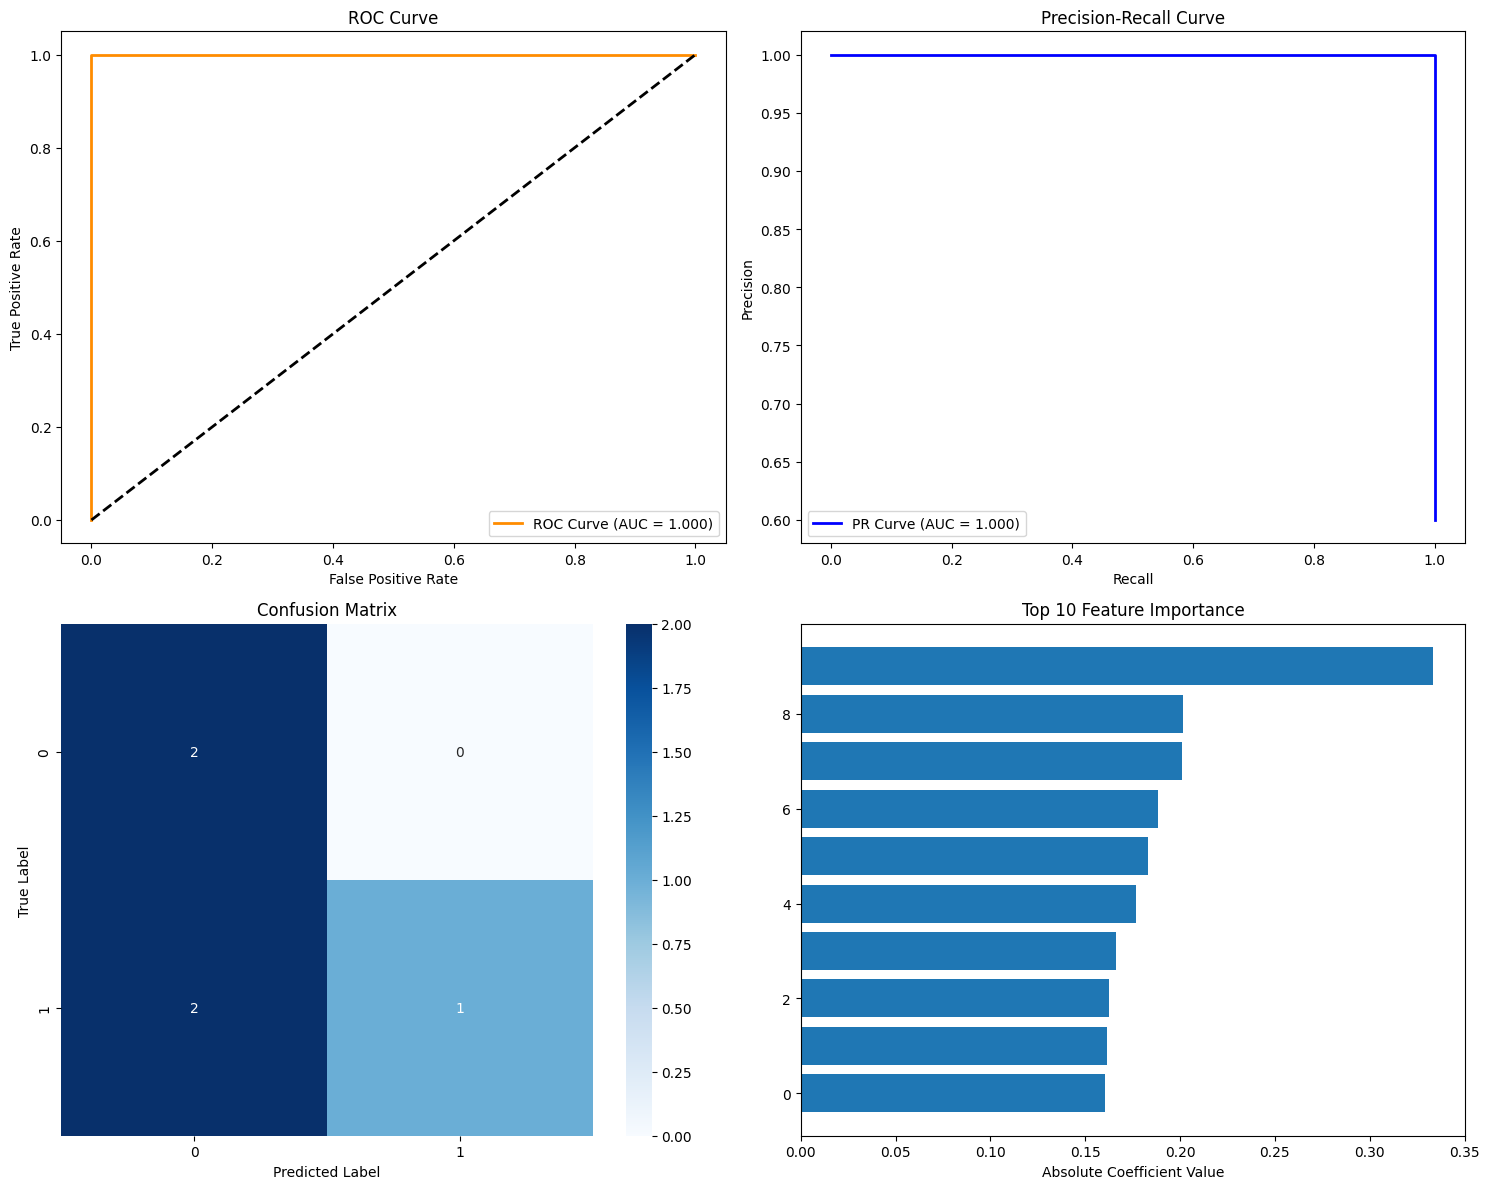


Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.33      0.50         3

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5


🔍 Analyzing embedding similarities...


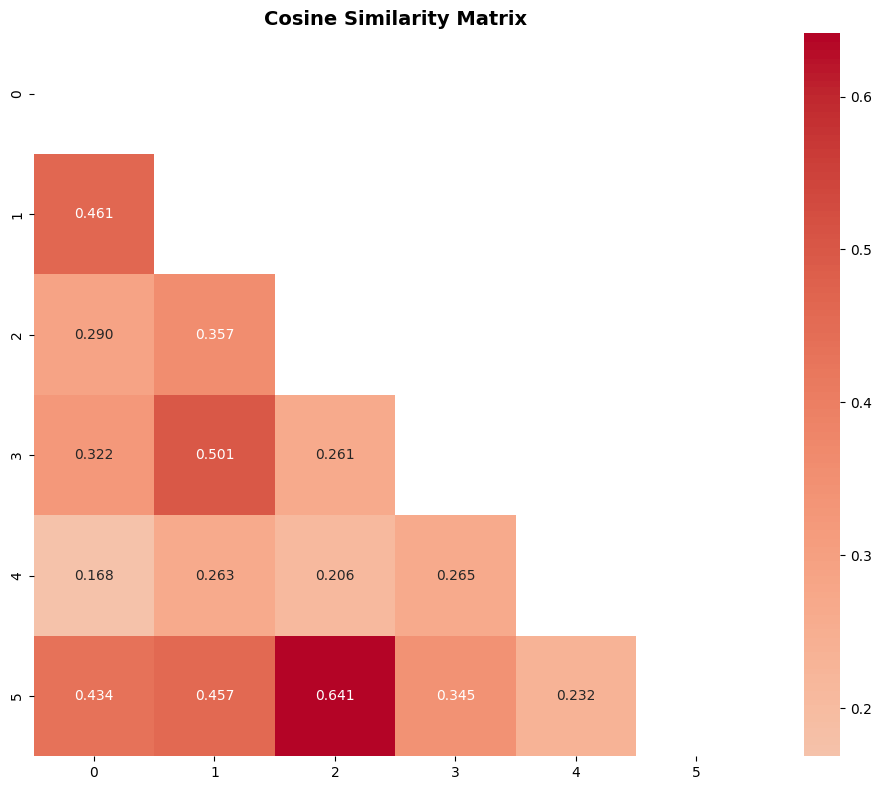


📋 SUMMARY RESULTS:
🎯 ROC AUC: 1.000
🎯 PR AUC: 1.000
✅ Model trained successfully!


In [25]:
def exemplo_avaliacao_completa():
    """Complete working example with proper data"""
    
    print("🚀 EXEMPLO: AVALIAÇÃO COMPLETA COM EMBEDDINGS")
    print("=" * 60)
    
    # Create a larger, more realistic dataset
    texts_positive = [
        "I love this product, it's amazing!",
        "This is the best thing I've ever bought.",
        "Excellent quality and fast delivery.",
        "Highly recommend this to everyone.",
        "Perfect! Exactly what I needed.",
        "Outstanding service and great product.",
        "Very satisfied with my purchase.",
        "Great value for money, will buy again."
    ]
    
    texts_negative = [
        "This product is terrible, don't buy it.",
        "Worst purchase I've ever made.",
        "Poor quality and slow delivery.",
        "I regret buying this item.",
        "Completely disappointed with this product.",
        "Waste of money, very low quality.",
        "Awful experience, would not recommend.",
        "Broke after one day of use."
    ]
    
    # Combine data
    all_texts = texts_positive + texts_negative
    labels = [1] * len(texts_positive) + [0] * len(texts_negative)  # 1 = positive, 0 = negative
    
    print(f"📊 Dataset created:")
    print(f"   Total texts: {len(all_texts)}")
    print(f"   Positive samples: {sum(labels)}")
    print(f"   Negative samples: {len(labels) - sum(labels)}")
    
    # Load model and generate embeddings
    print("\n🤖 Loading model and generating embeddings...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(all_texts)
    
    print(f"   Embeddings shape: {embeddings.shape}")
    
    # Run comprehensive evaluation
    print("\n📈 Running comprehensive evaluation...")
    results = comprehensive_evaluation(embeddings, labels)
    
    # Analyze similarities
    print("\n🔍 Analyzing embedding similarities...")
    similarity_matrix = analyze_embedding_similarities(all_texts[:6], model)  # Show first 6 for clarity
    
    # Print summary
    print("\n📋 SUMMARY RESULTS:")
    print("=" * 40)
    print(f"🎯 ROC AUC: {results['roc_auc']:.3f}")
    print(f"🎯 PR AUC: {results['pr_auc']:.3f}")
    print(f"✅ Model trained successfully!")
    
    return results, similarity_matrix

# Execute the complete example
results, similarity_matrix = exemplo_avaliacao_completa()


### 🎯 **Métricas-Chave Explicadas**

#### 📊 **Precision@K**
- **Fórmula**: `Precision@K = Documentos Relevantes nos Top-K / K`
- **Interpretação**: "Dos K documentos que retornei, quantos são realmente relevantes?"
- **Exemplo**: Se busco por "Python" e nos top-3 resultados, 2 são relevantes → P@3 = 2/3 = 0.67

#### 📈 **Recall@K**
- **Fórmula**: `Recall@K = Documentos Relevantes Encontrados / Total de Relevantes`
- **Interpretação**: "Dos documentos relevantes que existem, quantos consegui encontrar?"
- **Exemplo**: Se existem 5 docs relevantes e encontrei 3 nos top-10 → R@10 = 3/5 = 0.60

#### 🎯 **Mean Reciprocal Rank (MRR)**
- **Fórmula**: `MRR = 1/posição_primeiro_relevante`
- **Interpretação**: "Quão rápido encontro o primeiro resultado relevante?"
- **Exemplo**: Primeiro relevante na posição 2 → MRR = 1/2 = 0.50

### 💡 **Dicas Educacionais**

1. **🎯 Precision vs Recall Trade-off**: Alta precision pode significar baixo recall e vice-versa
2. **📊 MRR é crucial**: Usuários geralmente olham apenas os primeiros resultados
3. **🔍 Distribuição de similaridades**: Revela muito sobre a qualidade dos embeddings
4. **⚖️ Balance é importante**: Nem muito similares (duplicação) nem muito diferentes (irrelevância)